# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [64]:
import numpy as np
D = np.loadtxt('../data/lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]
Y = Y.reshape(-1, 1)

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [71]:
import numpy as np
import copy
import matplotlib.pyplot as plt

def mse_loss(Y, preds):
    return ((Y-preds)**2).mean()


def l2_regularization(W, reg_strength):
    loss = reg_strength * np.sum(W ** 2)
    grad = 2 * reg_strength * W
    return loss, grad


def linear_softmax(X, W, Y):
    preds = X @ W
    loss = mse_loss(Y, preds)
    grad = 2*(X @ W-Y).T @ X
    return loss, grad.T


class LinearRegression():
    def __init__(self):
        self.W = None
        self.reg = 1.0

    def fit(self, X, y, val_X=None, val_y=None, batch_size=1000, learning_rate=1e-6, reg=1e-2,
            epochs=10000):
        self.reg = reg
        num_train = X.shape[0]
        num_features = X.shape[1]
        if self.W is None:
            self.W = 0.001 * np.ones((num_features, 1))

        loss_history = []
        loss_history_val = []
        for epoch in range(epochs):
            loss, dW = linear_softmax(X, self.W, y)
            loss_l2, dW_l2 = l2_regularization(self.W, reg)

            self.W -= learning_rate * (dW + dW_l2)
            loss += loss_l2
            loss_history.append(loss)
            if not(val_X is None):
                val_prediction = lr.predict(val_X)
                loss_history_val.append(lr.loss(val_y, val_prediction))
        if loss_history_val:
            return loss_history, loss_history_val
        return loss_history

    def predict(self, X):
        y_pred = np.dot(X, self.W)
        return y_pred
    
    def loss(self, Y, preds):
        loss_mse = mse_loss(Y, preds)
        loss_l2, _ = l2_regularization(self.W, self.reg)
        return loss_mse + loss_l2

Text(0, 0.5, 'Loss with L2')

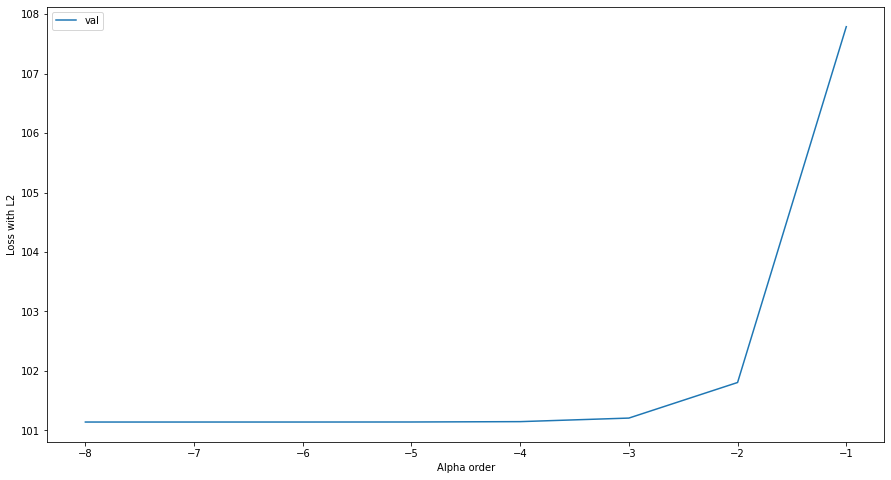

In [85]:
alphas = 10.0 ** np.arange(-8, 0)
val_history = []
fraction = 0.85
train_X, val_X = X[:int(fraction*X.shape[0])], X[int(fraction*X.shape[0]):]
train_y, val_y = Y[:int(fraction*Y.shape[0])], Y[int(fraction*Y.shape[0]):]

for alpha in alphas:
    lr = LinearRegression()
    loss_history, loss_history_val = lr.fit(train_X, train_y, val_X, val_y, epochs=5000, reg = alpha)
    val_history.append(loss_history_val[-1])

plt.figure(figsize=(15,8))
plt.plot(np.arange(-8, 0), val_history)
plt.legend(['val'])
plt.xlabel('Alpha order')
plt.ylabel('Loss with L2')

In [73]:
num_folds = 5
train_folds_X = []
train_folds_y = []
np.random.seed(2020)
num_samples = X.shape[0]
ind = [i for i in range(num_samples)]
np.random.shuffle(ind)
ind_folds = np.array_split(ind, num_folds)

for i in ind_folds:
    fold_X = []
    fold_y = []
    for j in i:
        fold_X.append(X[j])
        fold_y.append(Y[j])
    train_folds_X.append(np.array(fold_X))
    train_folds_y.append(np.array(fold_y))

alphas_to_mse = {}
losses = {alpha:[] for alpha in alphas}
losses_val = {alpha:[] for alpha in alphas}
for alpha in alphas:
    val_history = []

    for num_fold in range(num_folds):
        lr = LinearRegression()
        val_train_X = np.concatenate(np.delete(train_folds_X, num_fold, 0))
        val_train_y = np.concatenate(np.delete(train_folds_y, num_fold, 0))
        val_X, val_y = train_folds_X[num_fold], train_folds_y[num_fold]
        
        loss_history, loss_history_val = lr.fit(val_train_X, val_train_y, val_X, val_y, epochs=100, reg = alpha)
        losses[alpha].append(loss_history)
        losses_val[alpha].append(loss_history_val)
    losses[alpha] = np.array(losses[alpha]).mean(axis=0)
    losses_val[alpha] = np.array(losses_val[alpha]).mean(axis=0)

    alphas_to_mse[alpha] = losses_val[alpha][-1]


Optimal alpha is 1e-08


Text(0, 0.5, 'Loss with L2')

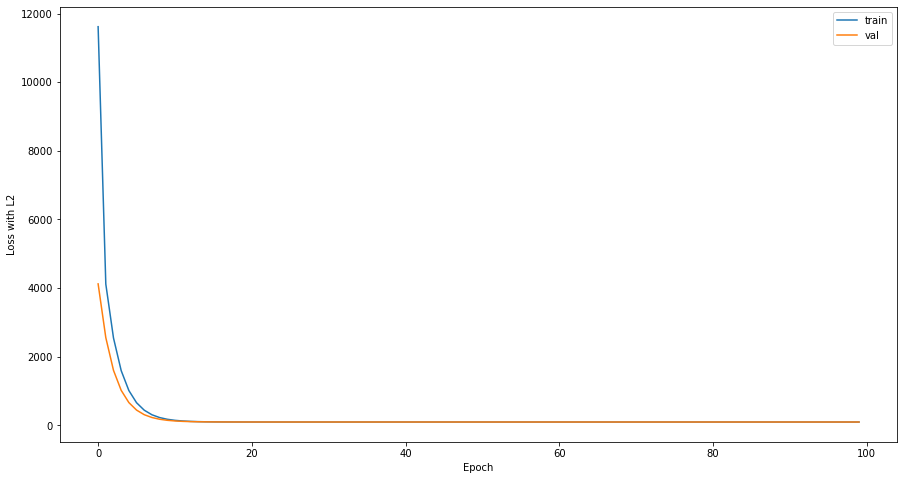

In [78]:
alpha, _ = sorted(alphas_to_mse.items(), key=lambda x:x[1])[0]
print("Optimal alpha is {}".format(alpha))
plt.figure(figsize=(15,8))
plt.plot(losses[alpha])
plt.plot(losses_val[alpha])
plt.legend(['train', 'val'])
plt.xlabel('Epoch')
plt.ylabel('Loss with L2')